In [76]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from math import *

In [77]:
f = lambda x: 1.35**x

xlim = 20
n_samples = 100         # astype('f') required for TensorFlow to prevent "TypeError: Input 'b' of 'MatMul'
truex = np.linspace(-xlim, xlim, n_samples).astype('f')  #  Op has type float32 that does not match type float64
truey = [f(_) for _ in truex]
rands = np.random.randn(n_samples).astype('f')          #  of argument 'a'." error

# this is a problem because consecutive batches aren't sampled similarly, so the cost doesn't converge
# in each consecutive batch
#randy = [exp(v + rands[i]) for i, v in enumerate(truex)]
shufx = np.copy(truex)
np.random.shuffle(shufx)
shufrandy = [f(v + rands[i]) for i, v in enumerate(shufx)]
shufrande = [f(v + rands[i]) - f(v) for i, v in enumerate(shufx)]

matplotlib.rcParams.update({'font.size': 12, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix', 'text.usetex': False})

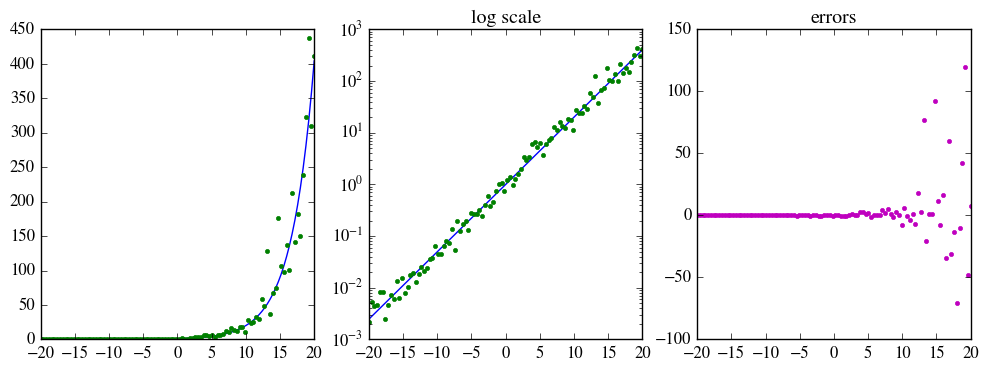

In [78]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].plot(truex, truey)
#ax[0].set_xlim(-xlim/4, xlim/4); ax[0].set_ylim(0, xlim*5); ax[0].grid(True)
ax[0].plot(shufx, shufrandy, 'g.')

ax[1].set_title('log scale')
ax[1].plot(truex, truey)
#ax[1].grid(True) #ax[1].set_xlim(-xlim/4, xlim/4); ax[1].set_ylim(0, xlim*5); 
ax[1].plot(shufx, shufrandy, 'g.')
ax[1].set_yscale("log")

ax[2].set_title('errors')
ax[2].plot(shufx, shufrande, 'm.');

In [79]:
import tensorflow as tf

In [80]:
# Parameters
learning_rate = 0.05
training_epochs = 500
batch_size = 10
display_step = training_epochs / 10

# Network Parameters
n_hidden_1 = 7 # 1st layer number of features (see note below)
n_hidden_2 = n_hidden_1 # 3 # 2nd layer number of features
n_input = 1 # value of X
n_output = 1 # value of Y

In [81]:
# Create model (https://wookayin.github.io/TensorflowKR-2016-talk-debugging/#15)
def multilayer_perceptron(input_layer, weights, biases):
    hidden_1 = tf.nn.relu(tf.matmul(input_layer, weights['h1'] ) + biases['b1'] )
    hidden_2 = tf.nn.relu(tf.matmul( hidden_1  , weights['h2'] ) + biases['b2'] )
    return                tf.matmul( hidden_2  , weights['out']) + biases['out']


In [82]:
# Store layers weight & bias
def construct_weights_biases(divisor=1):
    '''divisor allows for fewer degrees of freedom when predicting errors'''
    nh1 = int(n_hidden_1 / divisor)
    nh2 = int(n_hidden_2 / divisor)
    weights = {
        'h1': tf.Variable(tf.random_normal([n_input, nh1])),
        'h2': tf.Variable(tf.random_normal([nh1, nh2])),
        'out': tf.Variable(tf.random_normal([nh2, n_output]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([nh1])),
        'b2': tf.Variable(tf.random_normal([nh2])),
        'out': tf.Variable(tf.random_normal([n_output]))
    }
    return (weights, biases)

# Construct model w/ input/output placeholders
x = tf.placeholder(tf.float32, [None, 1])
y = tf.placeholder(tf.float32, [None, 1])
y_pred = multilayer_perceptron(x, *construct_weights_biases()) # the model, y predictions
y_cost = tf.pow(y_pred - y, 2)
y_pred_err = tf.log(y_cost) # tf.abs(y_pred - y) # log works great b/c then no need to complicate e_pred



# scrap all these attempts and just try neutralizing the ys by themselves (rather than neutralizing the
# errors).  this is, after all, what we want--for each datapoint to "count" the same



# try fitting errors with an exponential curve, if they fit, then it will be helpful, if they
# don't, then it won't matter b/c either it'll be a normal distribution (great!) or uniform (no fit--also great!)
b0 = tf.Variable(np.random.randn())
b1 = tf.Variable(np.random.randn())
b2 = tf.Variable(np.random.randn())
e_pred = tf.add(tf.add(b0, tf.mul(b1, x)), tf.mul(b2, tf.pow(x, 2)))
#e_pred = multilayer_perceptron(x, *construct_weights_biases(divisor=1)) # error predictions (fewer deg of freedom)
e_cost = tf.pow(e_pred - y_pred_err, 2) # tf.abs(e_pred - y_pred_err) # 

# components of the cost function
cost_raw  = tf.reduce_sum(y_cost)
#cost_norm = tf.reduce_sum(tf.div(y_cost, tf.exp(e_pred))) # dividing by a square (or exp) ensures a positive divisor
cost_norm = tf.reduce_sum(tf.exp(tf.log(y_cost) - e_pred/100.))
cost_err  = tf.reduce_sum(e_cost/100.)                   #  but then if error fn is linear-increasing low values
                                                    #   will have large divisors also, which is why exp is better!
    
# Define loss and optimizer (https://www.tensorflow.org/api_docs/python/nn/)
# for heteroskedastic functions, first learn the shape of the error/cost/loss, then learn the actual
# function of interest with a cost function that is normalized for the heteroskedasticity of the data
# similar to this: https://en.wikipedia.org/wiki/AdaBoost
cost = cost_norm + cost_err

# Optimizer overview: http://sebastianruder.com/optimizing-gradient-descent/
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# Initializing the variables
init = tf.global_variables_initializer()

In [83]:
pys = []
pes = []

# Launch the graph
with tf.Session() as sess:
    sess.run(init)

    # Training cycle
    for epoch in range(training_epochs):
        epoch_cost = 0.
        n_batches = int(n_samples / batch_size)
        
        # Loop over all batches
        for i in range(n_batches):
            bbegin = i * batch_size
            bend = min((i+1) * batch_size, n_samples)
            batch_x = np.array(    shufx[bbegin:bend]).reshape((bend - bbegin, 1))
            batch_y = np.array(shufrandy[bbegin:bend]).reshape((bend - bbegin, 1))

            # Run optimization op (backprop) and cost op (to get loss value)
            _, c, yout, eout, cr, cn, ce = (
                sess.run([optimizer, cost, y_pred, e_pred, cost_raw, cost_norm, cost_err],
                         feed_dict={x: batch_x, y: batch_y}))
            
            # compute average loss (note using reduce_sum, not reduce_avg, above)
            epoch_cost += c
            
            if epoch == 0 or epoch == training_epochs-1:
                print('  c={:10.1f}, cr={:8.1f}, cn={:8.1f}, ce={:8.1f}, log10(ce/cn)={:8.2f}'.format(c, cr, cn, ce, log10(ce/cn)))

            # debugging/printing output
            if epoch == 0 or epoch == training_epochs-1:
            
                # print last batch's costs
                if bbegin == 0:
                    batchout = []
                    for i in range(bend - bbegin):
                        xi = batch_x[i].reshape(1, 1)
                        yi = batch_y[i].reshape(1, 1)
                        ci, youti, eouti, cri, cni, cei = (
                            sess.run([cost, y_pred, e_pred, cost_raw, cost_norm, cost_err],
                                     feed_dict={x: xi, y: yi}))
                        batchout.append((batch_x[i,0], batch_y[i,0], youti[0,0], f(batch_x[i,0]), eouti[0,0], ci, cri, cni, cei))
                    for bo in sorted(batchout):
                        print('    Loss(x={:5.1f}, y={:5.1f}, py={:5.1f}, ty={:5.1f}, pe={:5.1f}) = {:6.1f} {:6.1f} {:6.1f} {:6.1f}'.format(*bo))
                    
            # save final predictions for plotting
            if epoch == training_epochs-1:
                for v in yout: pys.append(v)
                for v in eout: pes.append(exp(v))
            
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(epoch_cost / n_samples))
            
    print("Optimization Finished!")

  c= 2312671.8, cr=108750.0, cn=2309438.0, ce=  3233.6, log10(ce/cn)=   -2.85
    Loss(x=-20.0, y=  0.0, py= 95.6, ty=  0.0, pe=-318.6) = 222082.8 9135.9 221008.8 1074.0
    Loss(x= -9.5, y=  0.0, py= 46.5, ty=  0.1, pe=-69.7) = 4399.1 2161.8 4339.2   59.8
    Loss(x= -8.7, y=  0.1, py= 42.8, ty=  0.1, pe=-58.0) = 3297.6 1822.2 3254.7   42.9
    Loss(x= -6.3, y=  0.2, py= 31.4, ty=  0.2, pe=-29.4) = 1325.8  978.3 1312.7   13.2
    Loss(x= -5.1, y=  0.3, py= 26.3, ty=  0.2, pe=-18.7) =  819.9  674.7  813.6    6.4
    Loss(x= -3.0, y=  0.4, py= 17.6, ty=  0.4, pe= -6.2) =  315.9  295.5  314.4    1.4
    Loss(x=  7.1, y= 12.9, py= 25.3, ty=  8.3, pe=-44.0) =  261.2  152.8  237.2   24.0
    Loss(x=  8.3, y= 13.4, py= 30.3, ty= 12.0, pe=-59.7) =  563.7  286.7  521.0   42.7
    Loss(x= 17.2, y=141.7, py= 66.1, ty=173.0, pe=-248.6) = 69297.9 5711.9 68636.0  661.9
    Loss(x= 18.8, y=323.0, py= 72.6, ty=281.0, pe=-296.9) = 1220964.4 62677.4 1220016.2  948.1
  c= 3419464.8, cr=131370.7, cn=3416

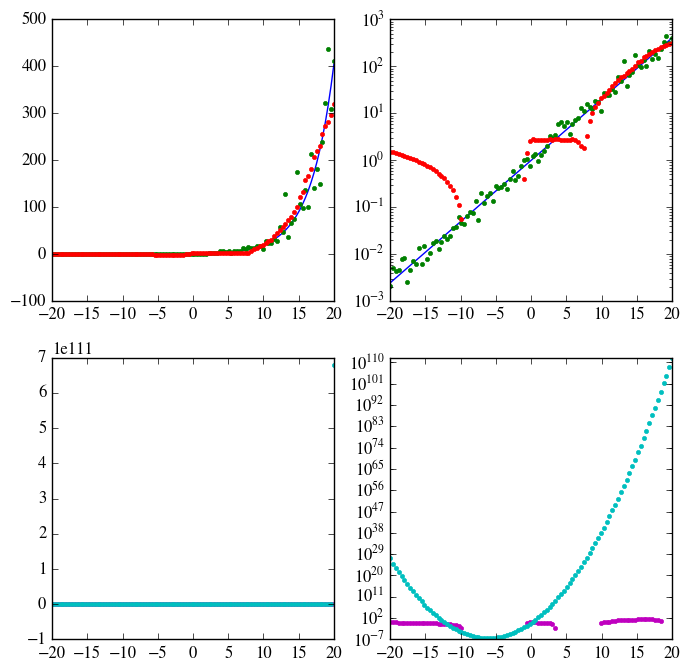

In [84]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

ax[0][0].plot(truex, truey)
#ax[0].set_xlim(-xlim/4, xlim/4); ax[0].set_ylim(0, xlim*5); ax[0].grid(True)
ax[0][0].plot(shufx, shufrandy, 'g.')
ax[0][0].plot(shufx, pys, 'r.')

ax[0][1].plot(truex, truey)
#ax[1].grid(True) #ax[1].set_xlim(-xlim/4, xlim/4); ax[1].set_ylim(0, xlim*5); 
ax[0][1].plot(shufx, shufrandy, 'g.')
ax[0][1].plot(shufx, pys, 'r.')
ax[0][1].set_yscale("log")

# errors
es = [py - f(shufx[i]) for i, py in enumerate(pys)]
ax[1][0].plot(shufx, es, 'm.');
ax[1][0].plot(shufx, pes, 'c.');
ax[1][1].plot(shufx, es, 'm.');
ax[1][1].plot(shufx, pes, 'c.');
ax[1][1].set_yscale("log")